# Clustering Using Pairwise Comparison

Clustering GP bitmaps

## Application to Preference Shopping

According to the work of R. Srikant, it is possible to cluster users based on incomplete information on their purchasing preferences. They achieve this by converting an (Mx2) matrix about the choices of users over products into an (M) 'net wins matrix'.

For instance assume we have 4 products (r1, r2, r3, r4) and 3 users (u1, u2, u3). We use the following encoding: if a user picks r1 over r2 (r1 > r2) then (r1,r2)=1 and (r2,r1)=-1; if we do not have a preferred choice (this accounts for incomplete information) between r3 and r4 then the encoding is (r3,r4)=0.

A sample matrix may take the form:

| u |(r1,r2) | (r1,r3) | (r1,r4) | (r2,r3) | (r2,r4) | (r3,r4) |
| :--- | :---: | :---: | :---: | :---: | :---: | :---: |
| u1 | 1 | 0 | 0 | -1 | 1 | 0 |
| u2 | 0 | 1 | 0 | -1 | 0 | 0 |
| u3 | 1 | -1 | 0 | 0 | 1 | 0 |


Using the available preference information, we can convert this matric into a 'net wins matrix' as shown below (i.e., for each item if it has more wins than losses then it is 1; if it has more losses than wins then it is -1; if the losses and equal to wins then it is 0; if it has no information then it is 0)

| u | r1 | r2 | r3 | r4 |
| --- | --- | --- | --- | --- |
| u1 | 1 | -1 | 1 | -1 |
| u2 | 1 | -1 | 0 | 0 |
| u3 | 0 | 0 | 1 | -1 |

We can use this new matrix to cluster users based on their purchase preferences using spectral clustering. Users in the same cluster have the same **score vector**

## Application to GP Mining

In order to mine for GPs, each feature has to construct a bitmap matrix comparing each row to each other (i.e., (r1,r2), (r1,r3), (r1,r4), (r2,r3), (r2,r4), (r3,r4)).

We can apply the same approach here, such that, we only construct the bitmap matrix with a handful of rows then convert them into 'net wins matrices'. Finally, we apply spectral clustering to determine which features belong to the same group based on the similarity of gradual dependency.

Gradual items in the same cluster have the same **score vector** (i.e., similar net wins matrices - at this point we do not know if the matrices yield a support that exceeds minimum threshold).

# Install Libraries

In [276]:
# Installing Libraries (if not installed)
#!pip3 install jupyterlab-git
#!pip3 install voila
#!pip3 install matplotlib
#!pip3 install scikit-learn
#!pip3 install seaborn
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install so4gp
#!pip3 install scipy
#!pip3 install sympy
#!pip3 install networkx
#!pip3 install choix

# Import libraries <a name="lib-import"></a>

In [57]:
# Importing Libraries
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import choix

from numpy.linalg import svd
from sklearn.cluster import KMeans, SpectralClustering, MiniBatchKMeans, Birch, AgglomerativeClustering


In [3]:
import so4gp as sgp

# Data set
Retrieving data set and the features

In [277]:
ds = sgp.DataGP('../data/DATASET.csv', min_sup=0.5)
#ds = sgp.DataGP('../data/c2k_02k.csv')
ds = sgp.DataGP('../data/breast_cancer.csv', min_sup=0.5)


data_size = ds.row_count
feature_size = ds.col_count
features = np.array(ds.data, dtype=np.float64)
features

array([[ 48.        ,  23.5       ,  70.        , ...,   7.99585   ,
        417.114     ,   1.        ],
       [ 83.        ,  20.69049454,  92.        , ...,   4.06405   ,
        468.786     ,   1.        ],
       [ 82.        ,  23.12467037,  91.        , ...,   9.27715   ,
        554.697     ,   1.        ],
       ...,
       [ 65.        ,  32.05      ,  97.        , ...,  10.33      ,
        314.05      ,   2.        ],
       [ 72.        ,  25.59      ,  82.        , ...,   3.27      ,
        392.46      ,   2.        ],
       [ 86.        ,  27.18      , 138.        , ...,   4.35      ,
         90.09      ,   2.        ]])

# Clustering GPs using Gradual Pairs

## a. Constructing Pair Matrix
We construct gradual pairs using the following encoding:

if r1 > r2, then (r1,r2) = 1

if r1 < r2 then (r1,r2) = 0

if r1 == r2 then (r1,r2) = 0


In [293]:
# Function for constructing GP pairs for Mx2 matrix

def construct_net_wins():
    net_wins = []
    win_cols = []
    ds.init_attributes()
    attr_data = features.T
    for bitmap_gp in ds.valid_bins:
        G = nx.from_numpy_array(bitmap_gp[1], create_using=nx.DiGraph)
        strength = np.round(choix.ilsr_pairwise(len(G.nodes()), G.edges(), alpha=0.01),2)
        
        #similar_wins = np.unique(strength, return_counts=True)[1]
        #supp = np.max(similar_wins) / ds.row_count
        #if supp <= ds.thd_supp:
            # Remove features will so many equal wins
            #net_wins.append(np.argsort(strength))
            #strength[strength > 0] = 1
            #strength[strength < 0] = -1
        net_wins.append(strength)
        win_cols.append(bitmap_gp[0])
    return np.array(win_cols), np.array(net_wins)
    

## b. Bulding the Net Wins Matrix

We construct a Net Wins matrix as follows

In [294]:
f, N = construct_net_wins()

print("Dimensions of net wins matrix: " + str(N.shape))
print('Rank of the matrix:', np.linalg.matrix_rank(N))
N

Dimensions of net wins matrix: (18, 116)
Rank of the matrix: 18


array([[-1.44,  5.42,  5.31, ...,  2.02,  3.89,  5.69],
       [ 2.56, -7.66, -7.21, ..., -0.74, -3.56, -9.18],
       [-2.2 , -8.04, -2.63, ...,  4.26, -1.11,  0.33],
       ...,
       [ 2.81,  5.58,  2.03, ...,  1.21,  5.78,  5.3 ],
       [ 0.22,  0.67,  1.73, ..., -2.05, -0.37, -9.26],
       [ 1.21,  0.77, -0.37, ...,  3.  ,  1.73,  5.71]])

## c. Spectral Clustering Using SVD and KMeans Algorithm

### i. Low Rank r approximation using SVD

We compute singular value decomposition (SVD) values in order to determine the number of clusters - approximately equal to the number of the ranks (or real vectors whose values are very large compared to the rest). This is known *rank r approximation*.

Tutorial: [nla.skoltech.ru](https://nla.skoltech.ru/lectures/html/08%2004%20Matrix%20rank,%20low-rank%20approximation,%20SVD.html)

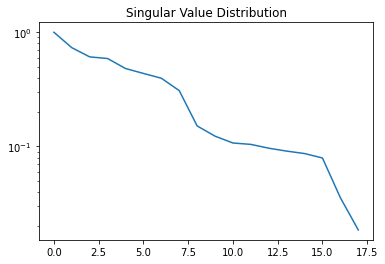

In [281]:
# Perform single value distribution to determine the independent rows
U, S, VT = svd(N)
Sd = np.diag(S)
#print(S)

plt.figure(1)
#plt.plot(S)
plt.semilogy(S/S[0])
plt.title('Singular Value Distribution')
plt.show()

In [282]:
r = np.linalg.matrix_rank(N)
r

18

In [283]:
Napprox = U[:,:r] @ np.diag(S[:r]) @ VT[:r,:]  # r rank approximation
er = np.linalg.norm(Napprox - N, 'fro') / np.linalg.norm(N, 'fro')

print("Dimensions of net wins matrix: " + str(Napprox.shape))
print('Rank of the matrix:', np.linalg.matrix_rank(Napprox))
print("Error: "+str(er))

Napprox

Dimensions of net wins matrix: (18, 116)
Rank of the matrix: 18
Error: 1.8197319586127117e-15


array([[-1.44,  5.42,  5.31, ...,  2.02,  3.89,  5.69],
       [ 2.56, -7.66, -7.21, ..., -0.74, -3.56, -9.18],
       [-2.2 , -8.04, -2.63, ...,  4.26, -1.11,  0.33],
       ...,
       [ 2.81,  5.58,  2.03, ...,  1.21,  5.78,  5.3 ],
       [ 0.22,  0.67,  1.73, ..., -2.05, -0.37, -9.26],
       [ 1.21,  0.77, -0.37, ...,  3.  ,  1.73,  5.71]])

### ii. Clustering using KMeans algorithm

Cluster the rows of the rank r projection using K-Means algorithm


In [284]:
# Using normal KMeans and N

kmeans = KMeans(n_clusters=r, random_state=0)
y_pred_N = kmeans.fit_predict(N)
print("Clusters predicted using original Net Matrix: " + str(y_pred_N))

Clusters predicted using original Net Matrix: [ 9  8 15 14  5 12 16  3  6 17  1  2  0 10  4  7 11 13]


In [285]:
# Using normal KMeans and Napprox

kmeans = KMeans(n_clusters=r, random_state=0)
y_pred_km = kmeans.fit_predict(Napprox)
print("Clusters predicted using approximated Net Matrix: " + str(y_pred_km))

Clusters predicted using approximated Net Matrix: [ 9  8 15 14  5 12  6  3 16 17  1  2  0 10  4  7 11 13]


In [286]:
# Using MiniBatchKMeans and Napprox

kmeans = MiniBatchKMeans(n_clusters=r)
y_pred_mbkm = kmeans.fit_predict(Napprox)
print("Clusters predicted using approximated Net Matrix: " + str(y_pred_mbkm))

Clusters predicted using approximated Net Matrix: [ 6  0  7 14  4  0  8  0  1  0 11 14  5 10 12  2 15  2]


In [287]:
# Create scatter plot

#clusters = np.unique(y_pred_km)
#plt.figure(1)
#for cluster in clusters:
#    row_ix = np.where(y_pred_km == cluster)
#    plt.scatter(Napprox[row_ix,1], Napprox[row_ix, 1])
#plt.title('Scatter Plot')
#plt.show()

### iii. Clustering using Spectral Clustering


In [288]:
# Using Spectral Clustering and Napprox

spectral_model = SpectralClustering(n_clusters=r)
y_pred_sc = spectral_model.fit_predict(Napprox)
print("Clusters predicted using approximated Net Matrix: " + str(y_pred_sc))

Clusters predicted using approximated Net Matrix: [3 3 3 3 3 3 0 4 2 1 3 3 3 3 3 3 3 3]


/usr/local/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:366: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  est = KMeans(


### iv. Other Clustering Techniques

In [289]:
# Using Agglomerative Clustering and Napprox

model = AgglomerativeClustering(n_clusters=r)
y_pred_ac = model.fit_predict(Napprox)
print("Clusters predicted using approximated Net Matrix: " + str(y_pred_ac))

Clusters predicted using approximated Net Matrix: [15 17 16 14 10 11  7  8  3 13  9  6 12  4  5  2  1  0]


In [290]:
# Using Birch Clustering and Napprox

model = Birch(threshold=0.01, n_clusters=r)
y_pred_bc = model.fit_predict(Napprox)
print("Clusters predicted using approximated Net Matrix: " + str(y_pred_bc))

Clusters predicted using approximated Net Matrix: [15 17 16 14 10 11  7  8  3 13  9  6 12  4  5  2  1  0]


### v. Infering GPs from clusters

We use the clusters to infer GPs

In [291]:
y_pred = y_pred_km
idx_grp = [np.where(y_pred == element)[0] for element in np.unique(y_pred)]
print("Clusters: ")
idx_grp

Clusters: 


[array([12]),
 array([10]),
 array([11]),
 array([7]),
 array([14]),
 array([4]),
 array([6]),
 array([15]),
 array([1]),
 array([0]),
 array([13]),
 array([16]),
 array([5]),
 array([17]),
 array([3]),
 array([2]),
 array([8]),
 array([9])]

In [292]:
# Infer GPs from the clusters
for grp in idx_grp:
    if grp.size > 1:
        gis = f[grp]
        gp = sgp.GP()
        for obj in gis:
            gi = sgp.GI(np.int32(obj[0]), obj[1].decode())
            gp.add_gradual_item(gi)
        print(gp.print(ds.titles)[0])


### iv. Compare with actual GPs

We mine the actual GPs using GRAANK algorithm and compare our results. We set the minimum support threshold to 0.5

In [19]:
# Mine GPs using existing GRAANK algorithm
#json.loads(sgp.graank('../data/breast_cancer.csv', min_sup=0.5))
#json.loads(sgp.graank('../data/c2k_02k.csv', min_sup=0.5))
json.loads(sgp.graank('../data/DATASET.csv', min_sup=0.5))

{'Algorithm': 'GRAANK',
 'Patterns': [[['Age+', 'Salary+'], 0.6],
  [['Age+', 'Expenses-'], 1.0],
  [['Age-', 'Salary-'], 0.6],
  [['Expenses+', 'Age-'], 1.0],
  [['Salary+', 'Expenses-'], 0.6],
  [['Expenses+', 'Salary-'], 0.6],
  [['Age+', 'Salary+', 'Expenses-'], 0.6],
  [['Expenses+', 'Age-', 'Salary-'], 0.6]]}

### Vi. Discussions

So far, KMeans gives the best results.

#### Mis-clustered GPs
We compare the GPs obtained through clustering and the actual GPs. And these 2 GPs are mis-clustered:

* 'Resistin+', 'Classification+'
* 'Glucose-', 'Classification-'